In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import os
os.getcwd()

'/content'

# ***Set parameters***

In [0]:
#Name of the Clustering algorithm
__algo__ = "KMEANS"               

#Name of the Word Embeddings used (glove, w2v, ftt), MUST set directory below
__emb__ = "use" #@param ["glove", "w2v", "ftt", "use"] {allow-input: true}

#Name of Sentence Embedding algorithm used
__sentemb__ = "use" #@param ["pmeans5", "normalmean", "use"] {allow-input: true}           

#Number of records to be read from files
recnum =                      30000#@param {type: "number"} 

#Number of Clusters
k =                             350#@param {type: "number"} 

usesqrt = False                   #@param ["False", "True"] {type:"raw", allow-input: true}

#Random Sampling to be True/False for records which are read
randomsample = True              #@param ["False", "True"] {type:"raw", allow-input: true} 

#Directory where embeddings are saved for that selected embedding
embedDir = "./drive/My Drive/ColabOutput/USESentEmbs_new" #@param ["./drive/My Drive/ColabOutput/FTXSentEmbs", "./drive/My Drive/ColabOutput/W2VSentEmbs", "./drive/My Drive/ColabOutput/MegaSentEmbs", "./drive/My Drive/ColabOutput/USESentEmbs_new"] {allow-input: true}


#Directory where models are saved
modelDir = "/content/drive/My Drive/Colab Notebooks/BTechProject_Venkatesh/models/"           

#Directory Where Megadf is to be saved
megadfDir = "/content/drive/My Drive/Colab Notebooks/BTechProject_Venkatesh/MegaDfs/"         

#Directory where plots are saved
plotDir = "/content/drive/My Drive/Colab Notebooks/BTechProject_Venkatesh/plots/"           

#Directory where performance and distribution params are to be stored
metadataDir = "/content/drive/My Drive/Colab Notebooks/BTechProject_Venkatesh/modelMetaData/" 

#Directory where test outcomes are saved
dumpDir = "/content/drive/My Drive/Colab Notebooks/BTechProject_Venkatesh/dump/"              

# Actual Code

### imports and time

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import cluster, datasets
from sklearn.metrics import silhouette_score, davies_bouldin_score
import seaborn as sns
import os, subprocess, sys
import datetime, time
import pickle

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### File Settings

In [11]:
oldlist = os.listdir(embedDir)
filelist = sorted([embedDir+f for f in oldlist if f[-3:]=="pkl"])
filenum = len(filelist)
templist = filelist[:filenum]
smalllist = [w[:44]+"/"+w[44:] for w in templist]
print("Length of Smalllist: ", len(smalllist))

Length of Smalllist:  50


### Number of Records
It is Recommended to Set this at the top parameters

In [0]:
recnum = recnum

In [13]:
smalllist[0]

'./drive/My Drive/ColabOutput/USESentEmbs_new/anatomy_N446.pkl'

In [0]:
def convert2normalmean(x):
  reqlen = int(len(x)/5)
  return x[:reqlen]

### Read all the pandas dataframes

In [15]:
%%time
megadf = pd.DataFrame()

if randomsample == True:
    print("randomsample: ", randomsample)
    for f in smalllist:
        tempdf = pd.read_pickle(f)
        # if __sentemb__ == "normalmean":
        #   tempdf["embedding"] = tempdf["embedding"].apply(convert2normalmean)
        megadf = megadf.append(tempdf, ignore_index = True)
    megadf = megadf.sample(recnum, random_state=42)
else:
    print("randomsample: ", randomsample)
    for f in smalllist:
        tempdf = pd.read_pickle(f)
        if __sentemb__ == "normalmean":
          tempdf["embedding"] = tempdf["embedding"].apply(convert2normalmean)
        megadf = megadf.append(tempdf, ignore_index = True)
        if megadf.shape[0] >= recnum:
            megadf = megadf[:recnum]
            break

print("megadf.shape: ", megadf.shape)

randomsample:  True
megadf.shape:  (30000, 6)
CPU times: user 637 ms, sys: 354 ms, total: 991 ms
Wall time: 48.9 s


In [18]:
predata_abs = megadf["Abstract_Embedding"]
data_abs = np.matrix(predata_abs.to_list())
print(data_abs.shape)
predata_title = megadf["Title_Embedding"]
data_title = np.matrix(predata_title.to_list())
print(data_title.shape)

(30000, 512)
(30000, 512)


In [0]:
# predata = megadf["embedding"]
# data = np.matrix(predata.to_list())
# print(data.shape)

### Number of Clusters
It is Recommended to Set this at the top parameters

In [19]:
if usesqrt == True:
    print("usesqrt: ", usesqrt)
    sqrt_k = int(np.sqrt(data.shape[0]))
    k = int(sqrt_k)
else:
    print("usesqrt: ", usesqrt)
    k = k
print("k: ", k)

usesqrt:  False
k:  350


## Clustering
Please modify the functions here to change algorithm

In [20]:
%%time
print("Starting Title Clustering Process")
start_time = time.time()
model_title = cluster.KMeans(n_clusters=k, n_init = 20, max_iter=1000, verbose=1, n_jobs=-1)
model_title.fit(data_title)
end_time = time.time()
timetrain = round(end_time-start_time, 2)
print("done! {}".format(timetrain))
print("k_means.fit(data) Done!")

Starting Title Clustering Process
done! 912.73
k_means.fit(data) Done!
CPU times: user 213 ms, sys: 182 ms, total: 395 ms
Wall time: 15min 12s


In [21]:
%%time
print("Starting Abstract Clustering Process")
start_time = time.time()
model_abs = cluster.KMeans(n_clusters=k, n_init = 20, max_iter=1000, verbose=1, n_jobs=-1)
model_abs.fit(data_abs)
end_time = time.time()
timetrain = round(end_time-start_time, 2)
print("done! {}".format(timetrain))
print("k_means.fit(data) Done!")

Starting Abstract Clustering Process
done! 834.49
k_means.fit(data) Done!
CPU times: user 207 ms, sys: 52.2 ms, total: 260 ms
Wall time: 13min 54s


### Saving the output data into vars

In [0]:
centroids_title = model_title.cluster_centers_
labels_title = model_title.labels_
megadf["clusterlabel_title"]=labels_title
centroidDF_title = pd.DataFrame(centroids_title)


In [0]:
centroids_abs = model_abs.cluster_centers_
labels_abs = model_abs.labels_
megadf["clusterlabel_abs"]=labels_abs
centroidDF_abs = pd.DataFrame(centroids_abs)


## Plotting

Text(0.5, 1.0, 'Title_KMEANS with k=350 records=30000 features=512 using use')

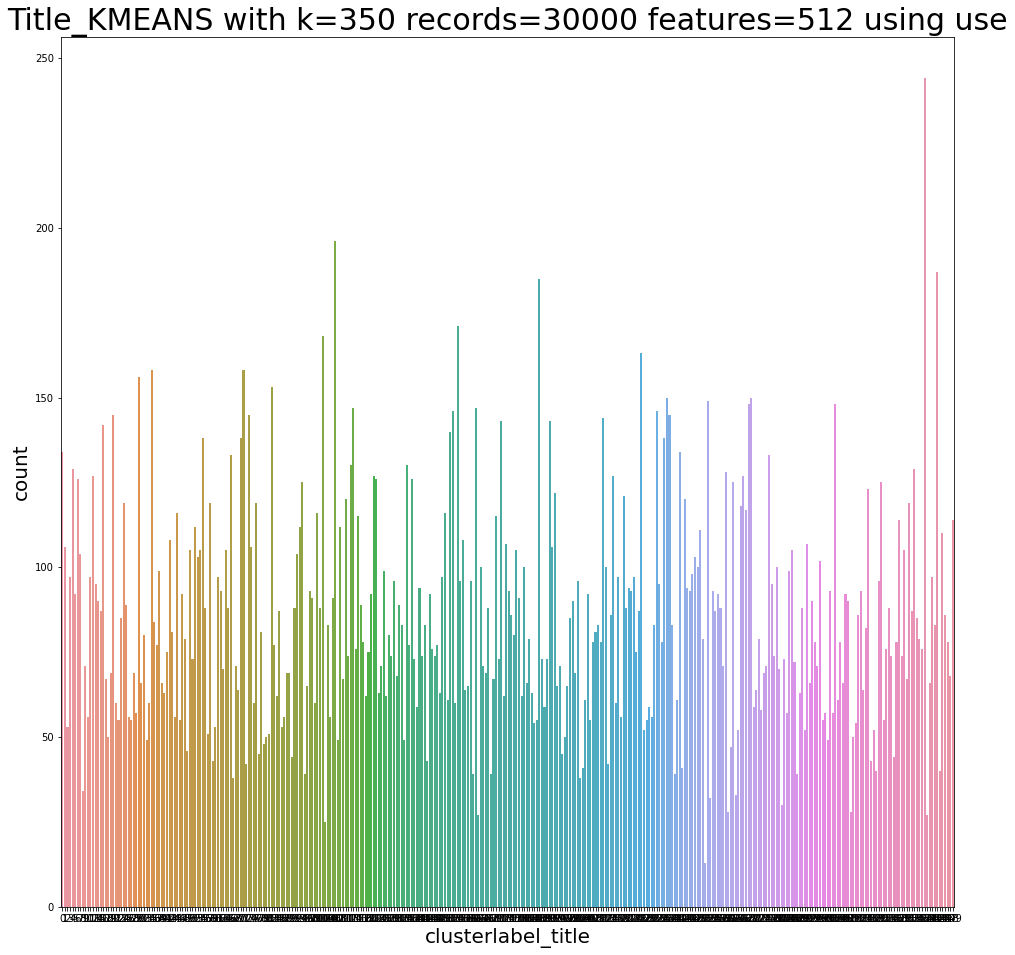

In [27]:
plt.figure(figsize=(16,16))
titlestring_title = "Title_{} with k={} records={} features={} using {}".format(__algo__, k, data_title.shape[0], data_title.shape[1], __emb__)
snsplot_title = sns.countplot("clusterlabel_title", data=megadf)
snsplot_title.xaxis.label.set_size(20)
snsplot_title.yaxis.label.set_size(20)
plt.title(
        titlestring_title,
        fontdict = {'fontsize' : 30}
    )

Text(0.5, 1.0, 'Abstract_KMEANS with k=350 records=30000 features=512 using use')

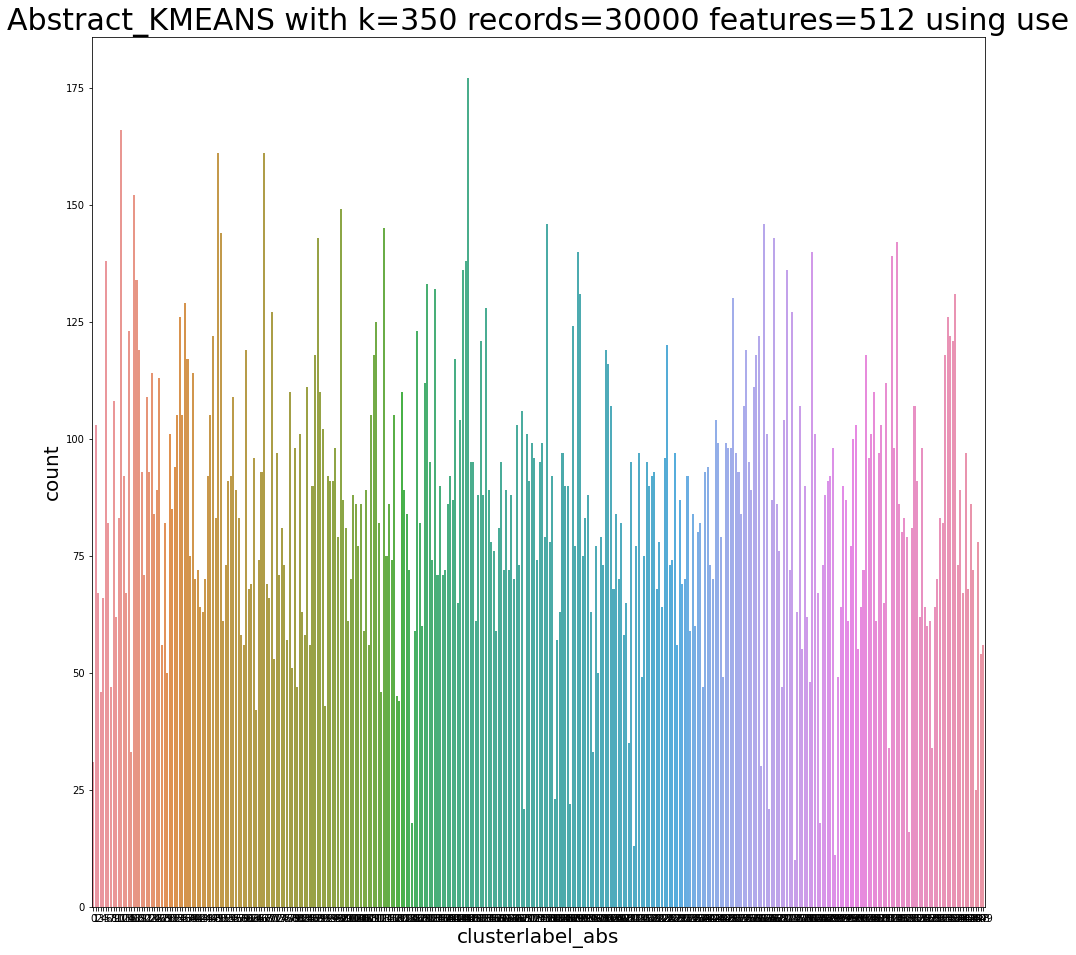

In [28]:
plt.figure(figsize=(16,16))
titlestring_abs = "Abstract_{} with k={} records={} features={} using {}".format(__algo__, k, data_abs.shape[0], data_abs.shape[1], __emb__)
snsplot_abs = sns.countplot("clusterlabel_abs", data=megadf)
snsplot_abs.xaxis.label.set_size(20)
snsplot_abs.yaxis.label.set_size(20)
plt.title(
        titlestring_abs,
        fontdict = {'fontsize' : 30}
    )

### *Name given to saved files*

In [31]:
features_title = data_title.shape[1]
records_title = data_title.shape[0]
name_title = "Title_{}_{}_{}_K{}_R{}_F{}".format(__algo__, __emb__, __sentemb__, k, records_title, features_title)
name_title

'Title_KMEANS_use_use_K350_R30000_F512'

In [32]:
features_abs = data_abs.shape[1]
records_abs = data_abs.shape[0]
name_abs = "Abstract_{}_{}_{}_K{}_R{}_F{}".format(__algo__, __emb__, __sentemb__, k, records_abs, features_abs)
name_abs

'Abstract_KMEANS_use_use_K350_R30000_F512'

### Saving Data

Save model

In [0]:
modelname = "{}_model_new.pkl".format(name_title)
pickle.dump(model_title, open(modelDir + modelname, 'wb'))
modelname = "{}_model_new.pkl".format(name_abs)
pickle.dump(model_abs, open(modelDir + modelname, 'wb'))

Save Plot

In [0]:
snspltname = "{}_plt_new.png".format(name_title)
snsplot_title.figure.savefig(plotDir + snspltname)
snspltname = "{}_plt_new.png".format(name_abs)
snsplot_abs.figure.savefig(plotDir + snspltname)

Save Megadf

In [0]:
clusterdfname = "Title_{}_clustered_megadf.pkl".format(name_title)
megadf.to_pickle(megadfDir + clusterdfname)
clusterdfname = "Abstract_{}_clustered_megadf.pkl".format(name_abs)
megadf.to_pickle(megadfDir + clusterdfname)

Save Centroids

In [37]:
centroidDF = pd.DataFrame(centroids_title)
centroidDFname = "Title_{}_centroids.pkl".format(name_title)
centroidDF.to_pickle(megadfDir + centroidDFname)
print(centroidDF.shape)
centroidDF = pd.DataFrame(centroids_abs)
centroidDFname = "Abstract_{}_centroids.pkl".format(name_abs)
centroidDF.to_pickle(megadfDir + centroidDFname)
print(centroidDF.shape)

(350, 512)
(350, 512)


done till here
#### Open dataframe to test


In [38]:
sub = megadf
sub.tail()

,id,Title,Abstract,Topic,Title_Embedding,Abstract_Embedding,clusterlabel_title,clusterlabel_abs
3028,http://arxiv.org/abs/1208.3151v1,Proceedings First International Workshop on Hy...,This volume contains the proceedings of the Fi...,biology,"[0.01301577, 0.0031270834, 0.021313373, -0.004...","[-0.009616074, -0.026493346, -0.039831344, -0....",254,228
2969,http://arxiv.org/abs/gr-qc/0612085v1,Compact binary inspiral and the science potent...,We consider EGO as a possible third-generation...,astrophysics,"[-0.010411776, 0.0033554635, -0.06325012, -0.0...","[-0.038154446, -0.060404133, -0.06930912, -0.0...",120,247
11664,http://arxiv.org/abs/1406.0420v3,Functional integral for optical parametric amp...,It is demonstrated that the nature of optical ...,education,"[0.05100013, -0.07577487, -0.014893429, 0.0307...","[0.008475766, -0.06747988, -0.02586603, -0.026...",286,137
26284,http://arxiv.org/abs/1310.6435v1,Hybrid-Logical Reasoning in False-Belief Tasks,The main aim of the present paper is to use a ...,psychology,"[0.03417307, -0.03494648, 0.03883823, -0.03149...","[0.030505227, -0.06303389, -0.05734635, -0.011...",11,30
27529,http://arxiv.org/abs/1611.03355v1,"Testing, Verification and Improvements of Time...",This paper addresses the problem of improving ...,robotics,"[-0.00491381, -0.072358996, 0.014917893, -0.06...","[0.027036197, -0.064679734, -0.04435448, -0.06...",307,172


In [39]:
megadf.columns

Index(['id', 'Title', 'Abstract', 'Topic', 'Title_Embedding',
       'Abstract_Embedding', 'clusterlabel_title', 'clusterlabel_abs'],
      dtype='object')

# Performance Testing and Distribution


In [0]:
metadata = pd.DataFrame(columns=["Name", "Algo", "WordEmb", "SentEmb", "K", "R", "F", "SS", "CSavg", "CSmin", "CSmax", "T2Pavg", "T2LM", "T2LMP", "MEM"])

In [0]:
metadict = {
    "Name":None,                     #Name of the save file prefix
    "Algo":None,                     #Name of the Clustering algorithm
    "WordEmb":None,                  #Name of the Word Embeddings used (glove, w2v, ftt)
    "SentEmb":None,                  #Name of Sentence Embedding algorithm used 
    "K":None, "R":None, "F":None,    #Number of clusters, records and fetures
    "T2T":None,                      #Time required to train model
    "SS":None,                       #Silhoutte Score
    "DBS":None,                      #Davis Bouldin Score
    "CSavg":None,                    #Average Cluster Size
    "CSmin":None,                    #Minimum Cluster Size
    "CSmax":None,                    #Maximum Cluster Size
    "T2Pavg":None,                   #Average Time To Predict cluster of one record
    "T2LM":None,                     #Average Time to Load Model
    "T2LMP":None,                    #Amortized time to Predict after loading the model
    "MEM":None                      #Memory used by the Model
    }
metadict

{'Algo': None,
 'CSavg': None,
 'CSmax': None,
 'CSmin': None,
 'DBS': None,
 'F': None,
 'K': None,
 'MEM': None,
 'Name': None,
 'R': None,
 'SS': None,
 'SentEmb': None,
 'T2LM': None,
 'T2LMP': None,
 'T2Pavg': None,
 'T2T': None,
 'WordEmb': None}

In [0]:
metadict["Name"]=name
metadict["Algo"]=__algo__
metadict["WordEmb"]=__emb__
metadict["SentEmb"]=__sentemb__
metadict["K"]=k
metadict["R"]=recnum
metadict["F"]=features
metadict

{'Algo': 'KMEANS',
 'CSavg': None,
 'CSmax': None,
 'CSmin': None,
 'DBS': None,
 'F': 250,
 'K': 350,
 'MEM': None,
 'Name': 'KMEANS_glove_pmeans5_K350_R30000_F250',
 'R': 30000,
 'SS': None,
 'SentEmb': 'pmeans5',
 'T2LM': None,
 'T2LMP': None,
 'T2Pavg': None,
 'T2T': None,
 'WordEmb': 'glove'}

#### Time to train

In [0]:
metadict["T2T"]=timetrain

#### Scores

In [0]:
ss = silhouette_score(data, labels, metric = 'euclidean')
dbs = davies_bouldin_score(data, labels)
metadict["SS"]=ss
metadict["DBS"]=dbs

#### Cluster Size

In [0]:
clusterdata = megadf.groupby("clusterlabel", as_index=True).size().reset_index(name="count")
clusterdata.head()

,clusterlabel,count
0,0,95
1,1,122
2,2,114
3,3,43
4,4,764


In [0]:
clusterdfname = "{}_clustered_counts.pkl".format(name)
clusterdata.to_pickle(megadfDir + clusterdfname)

In [0]:
countdata = clusterdata.groupby("count").size().reset_index(name="clusters")
display(countdata.head(3))
display(countdata.tail(3))

,count,clusters
0,3,1
1,6,2
2,9,2


,count,clusters
148,211,1
149,233,1
150,764,1


In [0]:
metadict["CSmax"] = max(clusterdata["count"])
metadict["CSmin"] = min(clusterdata["count"])
metadict["CSavg"] = np.mean(clusterdata["count"])

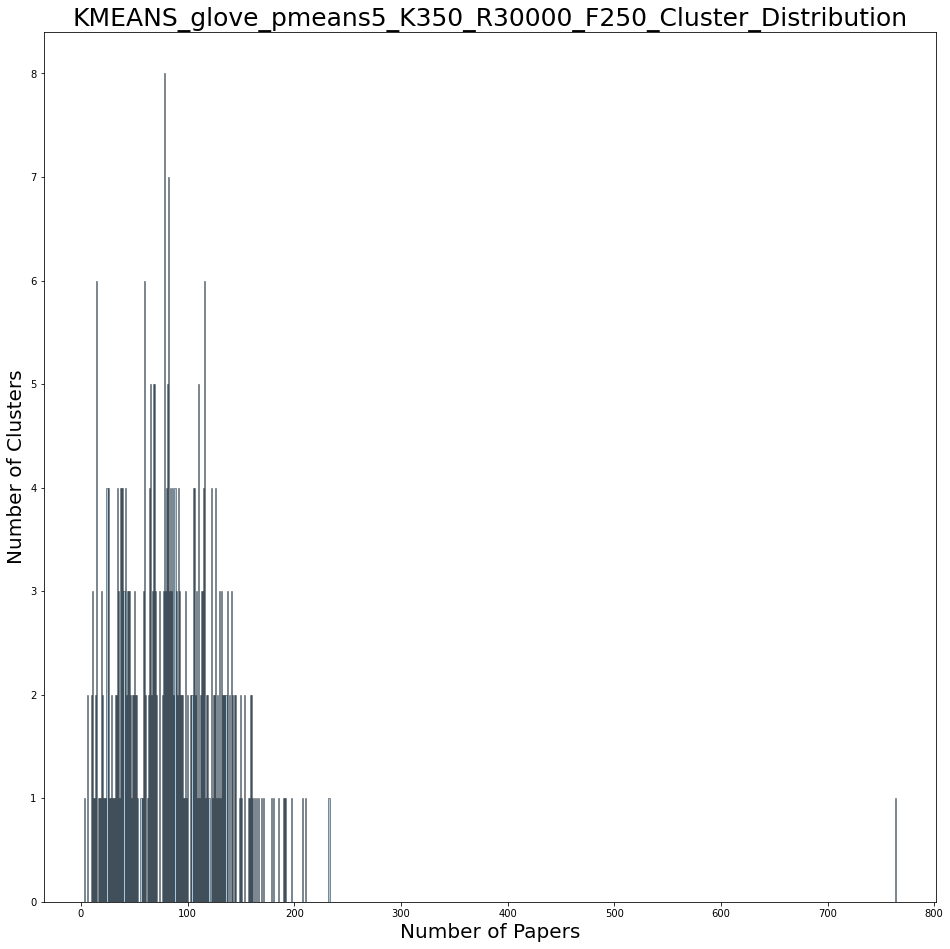

In [0]:
%matplotlib inline
plt.figure(figsize=(16,16))

sns.axes_style("whitegrid", {"axes.grid":True, 
                            'axes.spines.left': False,
                             'axes.spines.bottom': False,
                             'axes.spines.right': False,
                             'axes.spines.top': False})


titlestring = "{}_Cluster_Distribution".format(name)
snsplot = sns.distplot(clusterdata["count"], kde=False, bins=max(clusterdata["count"]),
                      hist_kws={'edgecolor':'black'},)
snsplot.set(xlabel="Number of Papers", ylabel="Number of Clusters")
snsplot.xaxis.label.set_size(20)
snsplot.yaxis.label.set_size(20)
plt.title(
        titlestring,
        fontdict = {'fontsize' : 25}
    )
plt.show()



In [0]:
snspltname = "{}_Cluster_Distribution.png".format(name)
snsplot.figure.savefig(plotDir + snspltname)

#### Prediction Time Performance

In [0]:
testdf = pd.DataFrame()
if recnum < 2000:
    samplenum = int(recnum / 10)
else:
    samplenum = 2000

for f in smalllist:
    tempdf = pd.read_pickle(f)
    if __sentemb__ == "normalmean":
      tempdf["embedding"] = tempdf["embedding"].apply(convert2normalmean)
    testdf = megadf.append(tempdf, ignore_index = True, sort = False)
testdf = testdf.sample(samplenum, random_state=int(time.time()%100000))
predata = testdf["embedding"]
data = np.matrix(predata.to_list())
print(data.shape)

(2000, 250)


In [0]:
print("Starting Predicting Performance")
testmodel = model
start_time = time.time()
for d in data:
    lb = testmodel.predict(d)
end_time = time.time()
timetest = end_time-start_time
avgtime = timetest/data.shape[0]
print("Avgtime: {} Totaltime: {}".format(avgtime, timetest))
metadict["T2Pavg"]=avgtime

Starting Predicting Performance
Avgtime: 0.0009195823669433593 Totaltime: 1.8391647338867188


In [0]:
print("Starting Loading Performance")
loadruns = 50
start_time = time.time()
for i in range(loadruns):
    testmodel = pickle.load(open(modelDir + modelname, 'rb'))
end_time = time.time()
timetest = end_time-start_time
avgtime = timetest/loadruns
print("Avgtime: {} Totaltime: {}".format(avgtime, timetest))
metadict["T2LM"] = avgtime
avgtime

Starting Loading Performance
Avgtime: 0.00234921932220459 Totaltime: 0.11746096611022949


0.00234921932220459

In [0]:
print("Starting Amortized Performance")
loadruns = 5
avglist = []

for i in range(loadruns):
    start_time = time.time()
    testmodel = pickle.load(open(modelDir + modelname, 'rb'))
    for d in data:
        lb = testmodel.predict(d)
    end_time = time.time()
    timetest = (end_time-start_time)/data.shape[0]
    avglist.append(timetest)

timetest = np.sum(avglist)
avgtime = np.mean(avglist)
print("Avgtime: {} Totaltime: {}".format(avgtime, timetest))
metadict["T2LMP"] = avgtime
avgtime

Starting Amortized Performance
Avgtime: 0.0009206844329833985 Totaltime: 0.004603422164916993


0.0009206844329833985

In [0]:
modelsize = sys.getsizeof(pickle.dumps(model))
print("modelsize:", modelsize, "bytes")
metadict["MEM"]=modelsize

modelsize: 820749 bytes


In [0]:
metadict

{'Algo': 'KMEANS',
 'CSavg': 85.71428571428571,
 'CSmax': 764,
 'CSmin': 3,
 'DBS': 3.551250995831387,
 'F': 250,
 'K': 350,
 'MEM': 820749,
 'Name': 'KMEANS_glove_pmeans5_K350_R30000_F250',
 'R': 30000,
 'SS': 0.062257379153006706,
 'SentEmb': 'pmeans5',
 'T2LM': 0.00234921932220459,
 'T2LMP': 0.0009206844329833985,
 'T2Pavg': 0.0009195823669433593,
 'T2T': 795.99,
 'WordEmb': 'glove'}

In [0]:
metadata = metadata.append(metadict, ignore_index=True)
metadata

,Name,Algo,WordEmb,SentEmb,K,R,F,SS,CSavg,CSmin,CSmax,T2Pavg,T2LM,T2LMP,MEM,DBS,T2T
0,KMEANS_glove_pmeans5_K350_R30000_F250,KMEANS,glove,pmeans5,350,30000,250,0.062257,85.714286,3,764,0.00092,0.002349,0.000921,820749,3.551251,795.99


In [0]:
metadataname = "{}_metadata.pkl".format(name)
metadata.to_pickle(metadataDir + metadataname)